In [1]:
!pip install matplotlib opencv-python diffusers transformers scipy accelerate optimum
# !pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from tira_utils import get_input_directory_and_output_directory, normalize_run
import pyterrier as pt
import pandas as pd
import os
import json
from tqdm import tqdm
from glob import glob
from pathlib import Path
from collections import Counter
import torch
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from PIL import Image
from transformers import pipeline

Start PyTerrier with version=5.7, helper_version=0.0.7, no_download=True


PyTerrier 0.9.1 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.
/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from preselection import retrieve

I will use a small hardcoded example located in /workspace/dataset22/.
The output directory is /tmp/


6749it [03:54, 30.41it/s]

10:56:54.514 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (I47e296f116f4c218) - further warnings are suppressed


23841it [12:52, 30.87it/s]


11:06:16.431 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Indexed 2 empty documents


In [4]:
def load_queries():
    file_name = 'dataset22/topics.xml'
    
    if not os.path.exists(file_name):
        raise ValueError(f'Could not find the file "{file_name}". Got: {glob(input_directory + "/*")}')
    
    topics = pd.read_xml(file_name)
    
    ret = pd.DataFrame()
    # https://github.com/terrier-org/pyterrier/issues/62\n",
    ret['query'] = topics['title'].apply(lambda i: "".join([x if x.isalnum() else " " for x in i]))
    ret['qid'] = topics['number']
    return ret

In [5]:
classifier = pipeline("zero-shot-classification", model='facebook/bart-large-mnli', accelerator="bettertransformer", device=0)

input_directory = '/workspace/dataset22/'

In [6]:
# load image text
# We use some very baseline method to get a textual representation: we just use the text of the pages that contain the image.
def load_image_text(image_id):
    ret = ''
    for txt_file in glob(input_directory +'/images/' + image_id[:3] + '/' + image_id + '/*/*/*/text.txt'):
        ret += '\n\n' + open(txt_file).read()
    return ret.strip()

def determine_stance(text, query):
    labels = ["contra "+ query, "pro "+ query, "neutral "+ query]
    result = classifier(text, labels)
    # sorts the labels starting with the most likely
    if result["labels"][0].startswith("contra"):
        return "contra", result["scores"][0]
    elif result["labels"][0].startswith("pro"):
        return "pro", result["scores"][0]
    else: 
        return "neutral", result["scores"][0]
    

def detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_ids, query, x):
    # get image ids from preranking
    # get image texts based on preranking 
    pro_imgs = {}
    contra_imgs = {}
    pro_ids = []
    contra_ids = []
    
    for image_id in image_ids:
        text = load_image_text(image_id)
        # deploy model
        stance, score = determine_stance(text, query)
        # print(image_id, stance, score)
        # separate pro and con texts; sort out neutral texts
        if stance == "pro":
            pro_imgs[image_id] = score
        elif stance == "contra": 
            contra_imgs[image_id] = score
            
    # sort according to scores
    sorted_pro = dict(sorted(pro_imgs.items(), key=lambda x:x[1], reverse=True))
    sorted_contra = dict(sorted(contra_imgs.items(), key=lambda x:x[1], reverse=True))
    # return best x results for each side
    i = 0
    for key in sorted_pro:
        if i < len(sorted_pro.keys()) and i < x:
            pro_ids.append(key)
        else: 
            break
        i += 1
    i = 0
    for key in sorted_contra:
        if i < len(sorted_contra.keys()) and i < x:
            contra_ids.append(key)
        else: 
            break
        i += 1
    return pro_ids, contra_ids, sorted_pro, sorted_contra
# not sorted right

In [7]:
def load_image_paths(image_ids):
    image_paths = []
    
    for image_id in image_ids:
        image_paths.append('dataset22/images/' + image_id[:3] + '/' + image_id + '/image.webp')
        
    return image_paths

In [8]:
def load_image_generator():
    with open('token.txt') as ifp:
        access_token = ifp.readline()
        # print('Read a token of length {}'.format( len(access_token) ))
    
    model_id = "CompVis/stable-diffusion-v1-4"
    device = "cuda"
    
    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, revision="fp16", use_auth_token=access_token, device_map="auto", cache_dir="stable_diffusion_cache")
    pipe = pipe.to(device)
    
    return pipe
    
def generate_image(pipe, prompt, isrealistic, image_name=None, guidance_scale=20, inference_steps=50):
    if isrealistic:
        final_prompt = "a photograph about the topic: " + prompt
    else:
        final_prompt = "an image in comic style about the topic: " + prompt
    
    print(final_prompt)
    
    image = None
    
    while image == None or not image.getbbox():
        image = pipe(final_prompt, guidance_scale=guidance_scale, num_inference_steps=inference_steps).images[0]
        print(not image.getbbox())

    if image_name != None:
        image.save("image_results/" + image_name + ".png")
    else:
        return image
    
def show_image(image_name):
    image = Image.open("image_results/" + image_name + ".png")
    image.show()

In [9]:
def flann_index_kdtree_matcher(image1, image2):
    MIN_MATCH_COUNT = 10
    
    # Initiate SIFT detector
    sift = cv.SIFT_create()
    
    image1_gray = cv.cvtColor(image1, cv.COLOR_RGB2GRAY)
    image2_gray = cv.cvtColor(image2, cv.COLOR_RGB2GRAY)

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(image1_gray, None)
    kp2, des2 = sift.detectAndCompute(image2_gray, None)
    
    if des1 is None or des2 is None:
        return [], 0
            
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    # Apply ratio test
    global good
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    
    if len(good) == 0:
        return [], 0
    
    most_common_keypoint_matches = Counter(x.trainIdx for x in good).most_common(1)[0]
    
    # single keypoint check for to many matches
    if most_common_keypoint_matches[1] > 10:
        return [], 0
            
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        
        if M is None:
            print("empty Homography on image")
            return [], 0
        
        matchesMask = mask.ravel().tolist()
        
        h,w, _ = image1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv.perspectiveTransform(pts,M)
        image2 = cv.polylines(image2,[np.int32(dst)],True,255,3, cv.LINE_AA)
             
    else:
        # print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None

    draw_params = dict(matchColor=(0, 255, 0),
                       singlePointColor=(255, 0, 0),
                       matchesMask=matchesMask,
                       flags=cv.DrawMatchesFlags_DEFAULT)
    
    img_matches = np.empty((max(image1.shape[0], image2.shape[0]), image1.shape[1]+image2.shape[1], 3), dtype=np.uint8)
    # img3 = cv.drawMatches(image1, kp1, image2, kp2, good, img_matches, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    img3 = cv.drawMatches(image1, kp1, image2, kp2, good, img_matches, **draw_params)
    
    # plt.imshow(img3, ), plt.show()
    
    return img3, len(good)

In [10]:
def sort_images(images, dataframe):
    sorted_images = []
    
    for i in range(len(images)):
        image_id = dataframe["image_id"][i]
        sorted_images.append(images[image_id])
    
    return sorted_images


def rank_images(images, image_name):
    print("image_results/" + image_name)
    topic_img = cv.cvtColor(cv.imread("image_results/" + image_name), cv.COLOR_BGR2RGB)
    image_ids = []
    match_numbers = []
    img_num = 0

    for image in images:
        # print(img_num)
    
        if image.size <= 100000000:
            img, good_matches = flann_index_kdtree_matcher(topic_img, image.copy())
        
            image_ids.append(img_num)
            match_numbers.append(good_matches)
    
        img_num += 1

    image_id_and_match_num_dataframe = pd.DataFrame({"image_id": image_ids, "match_num": match_numbers})
    sorted_image_id_and_match_num_dataframe = image_id_and_match_num_dataframe.sort_values(by=['match_num'], ascending=False).reset_index(drop=True)
    
    return sort_images(images, sorted_image_id_and_match_num_dataframe), sorted_image_id_and_match_num_dataframe


def update_image_id_and_match_num_dataframe(image_id_and_match_num_dataframe, curr_image_id_and_match_num_dataframe):
    for i in range(len(image_id_and_match_num_dataframe)):
        image_id = image_id_and_match_num_dataframe.iloc[i]["image_id"]
        
        for j in range(len(curr_image_id_and_match_num_dataframe)): 
            if image_id == curr_image_id_and_match_num_dataframe.iloc[j]["image_id"]:
                image_id_and_match_num_dataframe.iloc[i]["match_num"] += curr_image_id_and_match_num_dataframe.iloc[j]["match_num"]
        
    return image_id_and_match_num_dataframe


def combined_image_ranking(images, generated_image_names):
    image_id_and_match_num_dataframe = pd.DataFrame()
    
    for generated_image_name in generated_image_names:
        generated_image = cv.cvtColor(cv.imread("image_results/" + generated_image_name), cv.COLOR_BGR2RGB)
        image_ids = []
        match_numbers = []
        img_num = 0

        for image in images:
            if image.size <= 100000000:
                img, good_matches = flann_index_kdtree_matcher(generated_image, image.copy())
        
                image_ids.append(img_num)
                match_numbers.append(good_matches)
    
            img_num += 1
        
        if image_id_and_match_num_dataframe.empty:
            image_id_and_match_num_dataframe = pd.DataFrame({"image_id": image_ids, "match_num": match_numbers})
            print(image_id_and_match_num_dataframe)
        else:
            curr_image_id_and_match_num_dataframe = pd.DataFrame({"image_id": image_ids, "match_num": match_numbers})
            print(curr_image_id_and_match_num_dataframe)
            image_id_and_match_num_dataframe = update_image_id_and_match_num_dataframe(image_id_and_match_num_dataframe, curr_image_id_and_match_num_dataframe)
    
    sorted_image_id_and_match_num_dataframe = image_id_and_match_num_dataframe.sort_values(by=['match_num'], ascending=False).reset_index(drop=True)
    
    return sort_images(images, sorted_image_id_and_match_num_dataframe), sorted_image_id_and_match_num_dataframe
    

In [11]:
def show_multiple_images(image_list, row_count, col_count, save_image_name=None):
    for i in range(0, len(image_list), row_count*col_count):
        fig = plt.figure(figsize=(20, 20), dpi=80)
    
    for j in range(0, row_count*col_count):
        fig.add_subplot(row_count, col_count, j+1)
        plt.imshow(image_list[i+j])
        
    if save_image_name != None:
        save_path = "image_results/" + save_image_name
        plt.savefig(save_path)
        
    plt.show()

In [12]:
def createSubmissionFormat(preselection_data, ranked_image_id_dataframe, image_num=10):
    submission_format = ""
    rank = 1
    
    for i in range(image_num):
        local_image_id = ranked_image_id_dataframe["image_id"][i]
        
        image_data = preselection_data.iloc[local_image_id]
        query_id = image_data.loc["qid"]
        stance = stance_string
        image_id = image_data.loc["docno"]
        image_rank = rank
        image_score = 50 - (rank-1)
        method = "-"
        
        submission_format += (str(query_id) + " " + str(stance) + " " + str(image_id) + " " + str(image_rank) + " " + str(image_score) + " " + str(method) + "\n")
        
        rank += 1
        
    print(submission_format)

In [13]:
def pipeline(query_with_qid, stance_string, pipe, max_image_num=10):
    if stance_string == "pro":
        query_with_qid["query"].values[0] += " good"
    else:
        query_with_qid["query"].values[0] += " bad"
    
    preselection_data = retrieve(query_with_qid)
    image_docnos = preselection_data["docno"]
    print("preselection")
    
    query = query_with_qid["query"].values[0]
    
    pro_ids, con_ids, _, _ = detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_docnos, query, max_image_num)
    print("stance")
    
    image_ids = []
    if stance_string == "pro":
        image_ids = pro_ids
    else:
        image_ids = con_ids
    
    images = [cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB) for image_path in image_paths]
    print("get images")
    
    generate_image(pipe, query, True, "image_realistic.png")
    generate_image(pipe, query, False, "image_comic.png")
    print("images generated")
    
    ranked_images, sorted_image_id_and_match_num_dataframe = combined_image_ranking(images, ["image_realistic.png", "image_comic.png"])
    print("ranking")

    show_multiple_images(ranked_images, (max_image_num/2), 2)
    createSubmissionFormat(preselection_data, sorted_image_id_and_match_num_dataframe, stance_string)

In [12]:
queries = load_queries()

queries.iloc[[1]]["query"].values[0]

'Is vaping with e cigarettes safe '

In [26]:
pipe = load_image_generator()

Fetching 16 files: 100%|███████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 823.25it/s]


ZeroDivisionError: integer division or modulo by zero

a photograph about the topic: Vaping with e cigarettes dangerous


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:38<00:00,  1.31it/s]


False


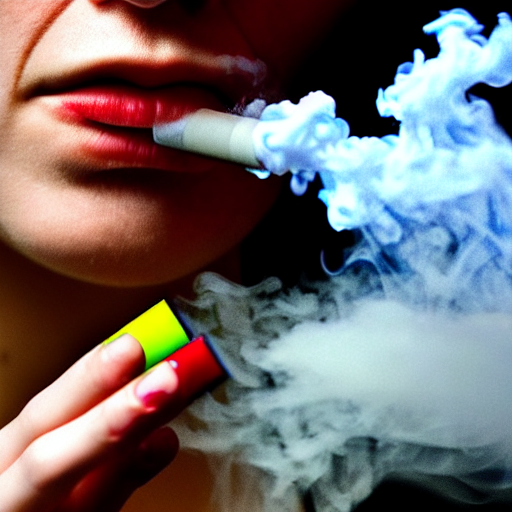

In [22]:
# "teachers_tenure"
# "vaping_cigarette"
# generate_image(pipe, queries.iloc[[1]]["query"].values[0], "vaping_cigarette2", False)
# generate_image(pipe, "Vaping with e cigarettes is safe", "vaping_cigarette_pro", True)
generate_image(pipe, "Vaping with e cigarettes dangerous", "vaping_cigarette_con", True)

show_image("vaping_cigarette_con")

In [24]:
queries = load_queries()
selected_query_with_qid = queries.iloc[[1]]
selected_query = selected_query_with_qid["query"].values[0]

preselection_data = retrieve(selected_query_with_qid)
image_docnos = preselection_data["docno"]

BR(BM25): 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.87s/q]


In [27]:
# selected_query_with_qid["query"].values[0] += " good"
selected_query_with_qid

,query,qid
1,Is vaping with e cigarettes safe good,2


In [34]:
max_image_num = 10
pro_ids, con_ids, sorted_pro, sorted_con = detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_docnos, selected_query, max_image_num)

/opt/conda/lib/python3.7/site-packages/transformers/pipelines/base.py:1048: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


In [104]:
pro_ids

['I31cfdcceb48fd16b',
 'I4c1dd664acef7f44',
 'I57b3d99281c71a10',
 'Ib2c49cc10a21fd60',
 'I10d92635503b5582',
 'I8549cc501ca54dcb',
 'Ifb7295b4440040a4',
 'Ia51cfbd8878e4cb3',
 'Iba870b1b759eb895',
 'I37af3d9148afb4d5']

In [ ]:
image_paths = load_image_paths(pro_ids)
images = [cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB) for image_path in image_paths]

ranked_images, sorted_image_id_and_match_num_dataframe = rank_images(images, "vaping_cigarette2.png")
show_multiple_images(ranked_images, 5, 2, "vaping_cigarette2_plot.png")
createSubmissionFormat(preselection_data, sorted_image_id_and_match_num_dataframe)

In [ ]:
image_paths = load_image_paths(con_ids)
images = [cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB) for image_path in image_paths]

ranked_images, sorted_image_id_and_match_num_dataframe = rank_images(images, "vaping_cigarette2.png")
show_multiple_images(ranked_images, 5, 2, "vaping_cigarette2_plot.png")
createSubmissionFormat(preselection_data, sorted_image_id_and_match_num_dataframe)

In [48]:
image1 = generate_image(pipe, "Vaping with e cigarettes safe", True)
image2 = generate_image(pipe, "Vaping with e cigarettes dangerous", False)

a photograph about the topic: Vaping with e cigarettes safe


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:43<00:00,  1.14it/s]


False
an image in comic style about the topic: Vaping with e cigarettes dangerous


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.13s/it]


False


NameError: name 'combined_image_ranking' is not defined

In [ ]:
ranked_images, sorted_image_id_and_match_num_dataframe = combined_image_ranking(images, ["vaping_cigarette_pro.png", "vaping_cigarette_con.png"])
sorted_image_id_and_match_num_dataframe

In [14]:
queries = load_queries()
selected_query_with_qid = queries.iloc[[1]]
diff_pipe = load_image_generator()

Fetching 16 files: 100%|███████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 863.05it/s]
/opt/conda/lib/python3.7/site-packages/transformers/models/clip/feature_extraction_clip.py:31: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  FutureWarning,


In [15]:
pipeline(selected_query_with_qid, "pro", diff_pipe, 10)

BR(BM25): 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/q]


preselection


/opt/conda/lib/python3.7/site-packages/transformers/pipelines/base.py:1048: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


stance


NameError: name 'image_paths' is not defined